# Modeling Crop Yield Anomaly
## Python modules

In [87]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date
import re

import numpy as np
import pandas as pd
import geopandas

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

In [88]:
def str2bool(string):
    return string.lower() in ("yes", "true", "t", "1")

point_pattern = re.compile("20k-points")
wa_pattern = re.compile("cm-False")

In [89]:
data_dir = here("data")
directory = here("data", "random_features", "summary")
today = date.today().strftime("%Y-%m-%d")
files = os.listdir(directory)
files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
files = [f for f in files if not (bool(point_pattern.search(f)) & bool(wa_pattern.search(f)))]
len(files)

44

In [90]:
def model(params):
#########################################     SET PARAMS    #########################################
    file         = params
    f            = file.split(sep="_")
    satellite    = f[0]
    bands        = f[1].replace("bands-", "")
    country_code = f[2]
    points       = f[3].replace("k-points", "")
    num_features = f[4].replace("-features", "")
    yrs          = f[5].replace("yr-", "").split(sep="-")
    mns          = f[6].replace("mn-", "").split(sep="-")
    limit_months = str2bool(f[7].replace("lm-", ""))
    crop_mask    = str2bool(f[8].replace("cm-", ""))
    weighted_avg = str2bool(f[9].replace("wa-", ""))
    years        = range(int(yrs[0]), int(yrs[1])+1)
    month_range  = list(range(int(mns[0]), int(mns[1])+1))

    alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    kfold  = KFold()
    logo   = LeaveOneGroupOut()
    ridge  = Ridge() 
#########################################     READ DATA    #########################################
    fn = f"{directory}/{file}"
    features = pd.read_feather(fn)

    drop_cols = ['district', 'year', 'yield_mt', 'crop_perc']

    if weighted_avg:
        drop_cols.remove("crop_perc")
    else:
        pass

#########################################    STANDARDIZE FEATURES    #########################################    
    features = features.set_index(drop_cols) 
    features_scaled = StandardScaler().fit_transform(features.values)
    features = pd.DataFrame(features_scaled, index=features.index).reset_index()

#########################################     CALCULATE ANOMALY   #########################################
    features['yield_mt'] = np.log10(features['yield_mt'] + 1)
    features.set_index(['year', 'district'], inplace=True)
    var_cols = features.columns
    features = features[var_cols] - features.groupby(['district'], as_index=True)[var_cols].transform('mean')
    features.reset_index(drop=False, inplace=True)

#########################################     K-FOLD SPLIT    #########################################
    x_all = features.drop(drop_cols, axis = 1) 
    y_all = features.yield_mt
    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD  CV   ###########################################
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
    kfold_ridge_reg.fit(x_train, y_train)
    kfold_best_model = kfold_ridge_reg.best_estimator_
    ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
    y_pred_train_k = kfold_best_model.predict(x_train)
    y_pred_test_k  = kfold_best_model.predict(x_test)

#########################################     SAVE RESULTS    #########################################
    d = {
        'country': country_code,
        'satellite': satellite,
        'bands': bands,
        'num_features': num_features,
        'points': points, 
        'month_range': f'{min(month_range)}-{max(month_range)}',
        
        'limit_months': limit_months,
        'crop_mask': crop_mask,
        'weighted_avg': weighted_avg,
        
        'kfold_total_n': len(x_all),
        'kfold_train_n': len(x_train),
        'kfold_test_n' : len(x_test),
        
        'kfold_best_reg_param': list(kfold_ridge_reg.best_params_.values())[0],
        'kfold_mean_of_val_R2s': kfold_ridge_reg.best_score_,
        'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
        'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
        'kfold_val_r2': pearsonr(kfold_val_predictions, y_train)[0] ** 2,
        
        'kfold_train_R2': r2_score(y_train, y_pred_train_k),
        'kfold_train_r' : pearsonr(y_pred_train_k, y_train)[0],
        'kfold_train_r2': pearsonr(y_pred_train_k, y_train)[0] ** 2,
        
        'kfold_test_R2': r2_score(y_test, y_pred_test_k),
        'kfold_test_r' : pearsonr(y_pred_test_k, y_test)[0],
        'kfold_test_r2': pearsonr(y_pred_test_k, y_test)[0] ** 2,
        
    }
    return pd.DataFrame(data=d, index=[0])

In [91]:
%%time     
##### With progress bar
workers = 44 ## os.cpu_count()
if __name__ == "__main__":
    output = []
    for result in p_tqdm.p_map(model, files, num_cpus=workers):
        output.append(result)
    results = pd.concat(output).reset_index(drop=True)
    today = date.today().strftime("%Y-%m-%d")
    file_name = f'anomaly_results_{today}.csv'
    print(f"Saving results as: {file_name}\n\n")           
    results.to_csv(here("data","results", file_name), index=False)

  0%|          | 0/44 [00:00<?, ?it/s]

Saving results as: anomaly_results_2022-12-17.csv


CPU times: user 507 ms, sys: 701 ms, total: 1.21 s
Wall time: 6min 37s


In [30]:

file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'

#########################################     SET PARAMS    #########################################
# file         = params
f            = file.split(sep="_")
satellite    = f[0]
bands        = f[1].replace("bands-", "")
country_code = f[2]
points       = f[3].replace("k-points", "")
num_features = f[4].replace("-features", "")
yrs          = f[5].replace("yr-", "").split(sep="-")
mns          = f[6].replace("mn-", "").split(sep="-")
limit_months = str2bool(f[7].replace("lm-", ""))
crop_mask    = str2bool(f[8].replace("cm-", ""))
weighted_avg = str2bool(f[9].replace("wa-", ""))
years        = range(int(yrs[0]), int(yrs[1])+1)
month_range  = list(range(int(mns[0]), int(mns[1])+1))

alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
kfold  = KFold()
logo   = LeaveOneGroupOut()
ridge  = Ridge() 
#########################################     READ DATA    #########################################
fn = f"{directory}/{file}"
features = pd.read_feather(fn)

drop_cols = ['district', 'year', 'yield_mt', 'crop_perc']

if weighted_avg:
    drop_cols.remove("crop_perc")
else:
    pass

crop_yield = features.copy().loc[:, tuple(drop_cols)]
crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)

#########################################    STANDARDIZE FEATURES    #########################################    
features = features.set_index(drop_cols) 
features_scaled = StandardScaler().fit_transform(features.values)
features = pd.DataFrame(features_scaled, index=features.index).reset_index()

#########################################     CALCULATE ANOMALY   #########################################
features['yield_mt'] = np.log10(features['yield_mt'] + 1)
features.set_index(['year', 'district'], inplace=True)
var_cols = features.columns
features = features[var_cols] - features.groupby(['district'], as_index=True)[var_cols].transform('mean')
features.reset_index(drop=False, inplace=True)

#########################################     K-FOLD SPLIT    #########################################
x_all = features.drop(drop_cols, axis = 1) 
y_all = features.yield_mt
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=0)

#########################################     K-FOLD  CV   ###########################################
### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
kfold_ridge_reg.fit(x_train, y_train)
kfold_best_model = kfold_ridge_reg.best_estimator_
### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
y_pred_train_k = kfold_best_model.predict(x_train)
y_pred_test_k  = kfold_best_model.predict(x_test)


In [31]:
r2_score(y_train, kfold_val_predictions)

0.30789352049310026

In [32]:
r2_score(y_test, y_pred_test_k)

0.2528558585632913

In [52]:
districts = crop_yield.district.unique().tolist()
predictions = pd.concat([x_train, x_test])
predictions['split'] = np.concatenate((np.repeat('train', len(x_train)), np.repeat('test', len(x_test))))
predictions['kfold_cv_predictions'] = np.concatenate((kfold_val_predictions,  np.repeat(np.nan, len(x_test))))
predictions = predictions[['split', 'kfold_cv_predictions']]
predictions = crop_yield.join(predictions)
predictions["district_yield_mean"] = predictions.groupby('district')['log_yield'].transform('mean')
predictions["demean_yield"] = predictions["log_yield"] - predictions["district_yield_mean"]

predictions["prediction"] = kfold_best_model.predict(x_all)
predictions["district_prediction_mean"] = predictions.groupby('district')['prediction'].transform('mean')
predictions["demean_prediction"] = predictions["prediction"] - predictions["district_prediction_mean"]
predictions["demean_cv_prediction"] = predictions["kfold_cv_predictions"] - predictions["district_prediction_mean"]
predictions

,district,year,yield_mt,crop_perc,log_yield,split,kfold_cv_predictions,district_yield_mean,demean_yield,prediction,district_prediction_mean,demean_prediction,demean_cv_prediction
0,Chadiza,2013,2.008807,0.787985,0.478394,train,-0.043555,0.501604,-0.023210,-0.038678,-0.000237,-0.038441,-0.043318
1,Chadiza,2014,2.407307,0.787985,0.532411,test,NaN,0.501604,0.030807,0.091504,-0.000237,0.091741,NaN
2,Chadiza,2015,2.023136,0.787985,0.480458,train,-0.012365,0.501604,-0.021146,-0.014062,-0.000237,-0.013825,-0.012128
3,Chadiza,2016,1.876427,0.787985,0.458853,train,-0.002106,0.501604,-0.042751,-0.013099,-0.000237,-0.012862,-0.001869
4,Chadiza,2017,2.882947,0.787985,0.589161,train,-0.030981,0.501604,0.087557,-0.011353,-0.000237,-0.011116,-0.030743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,Zambezi,2017,1.490456,0.312756,0.396279,test,NaN,0.451359,-0.055080,-0.007773,-0.000237,-0.007535,NaN
644,Zambezi,2018,1.622273,0.312756,0.418678,train,-0.031349,0.451359,-0.032681,-0.027531,-0.000237,-0.027294,-0.031112
645,Zambezi,2019,1.184923,0.312756,0.339436,test,NaN,0.451359,-0.111922,-0.029412,-0.000237,-0.029175,NaN
646,Zambezi,2020,1.689628,0.312756,0.429692,train,-0.016472,0.451359,-0.021666,-0.010883,-0.000237,-0.010646,-0.016234


In [53]:
r2_score(predictions.demean_yield, predictions.demean_prediction)

0.5695887042665209

In [54]:
cv_pred = predictions[predictions.split == 'train']
r2_score(cv_pred.demean_yield, cv_pred.demean_cv_prediction)

0.3077864952066104

In [55]:
test_pred = predictions[predictions.split == 'test']
r2_score(test_pred.demean_yield, test_pred.demean_prediction)

0.25295584834877305

In [56]:
pearsonr(cv_pred.demean_yield, cv_pred.demean_cv_prediction)[0] ** 2

0.3116092215505781

In [57]:
pearsonr(test_pred.demean_yield, test_pred.demean_prediction)[0] ** 2

0.2532787813937976

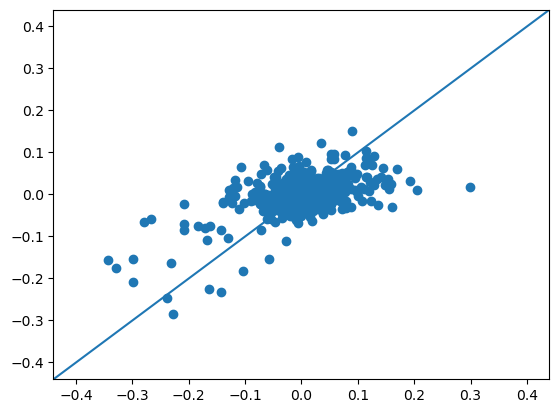

In [58]:
import matplotlib.pyplot as plt
plt.scatter(cv_pred["demean_yield"], cv_pred["demean_cv_prediction"])
plt.axline((-.4, -.4), (.4, .4))

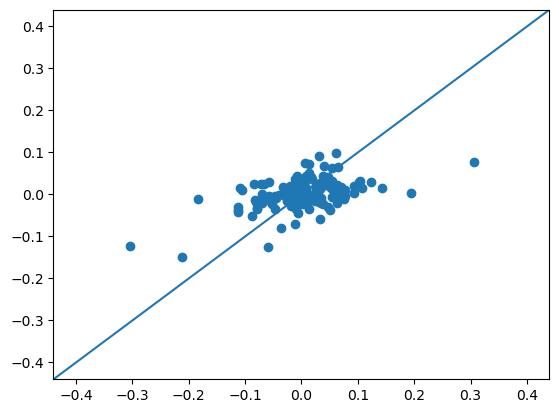

In [59]:
plt.scatter(test_pred["demean_yield"], test_pred["demean_prediction"])
plt.axline((-.4, -.4), (.4, .4))

In [62]:
# #########################################     SET PARAMS    #########################################
# file         = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
# f            = file.split(sep="_")
# satellite    = f[0]
# bands        = f[1].replace("bands-", "")
# country_code = f[2]
# points       = f[3].replace("k-points", "")
# num_features = f[4].replace("-features", "")
# yrs          = f[5].replace("yr-", "").split(sep="-")
# mns          = f[6].replace("mn-", "").split(sep="-")
# limit_months = str2bool(f[7].replace("lm-", ""))
# crop_mask    = str2bool(f[8].replace("cm-", ""))
# weighted_avg = str2bool(f[9].replace("wa-", ""))
# years        = range(int(yrs[0]), int(yrs[1])+1)
# month_range  = list(range(int(mns[0]), int(mns[1])+1))

# alphas = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
# kfold  = KFold()
# logo   = LeaveOneGroupOut()
# ridge  = Ridge() 
# #########################################     READ DATA    #########################################
# fn = f"{directory}/{file}"
# features = pd.read_feather(fn)
# features['yield_mt'] = np.log10(features['yield_mt'] + 1)
# drop_cols = ['year', 'crop_perc']

# if weighted_avg:
#     drop_cols.remove("crop_perc")
# else:
#     pass

# #########################################    FEATURES SPLIT    #########################################
# train_split, test_split = train_test_split(features, test_size=0.2, random_state=0)
# train_split['split'], test_split['split'] = 'train', 'test'
# features_split = pd.concat([train_split, test_split])

# #########################################    STANDARDIZE FEATURES    #########################################    
# features_split = features_split.set_index(['year', 'district', 'yield_mt', 'split']) 
# features_split_scaled = StandardScaler().fit_transform(features_split.values)
# features_split = pd.DataFrame(features_split_scaled, index=features_split.index).reset_index()
# features_split.columns = features_split.columns.astype(str)  

# #########################################     CALCULATE ANOMALY   #########################################
# drop_cols.append('district'), drop_cols.append('split') 
# features_split.set_index(drop_cols, inplace=True, append=True)
# features_split = features_split - features_split.groupby(['district', 'split'], as_index=True).transform('mean')
# features_split.reset_index(level=drop_cols, drop=False, inplace=True)

# #########################################    K-FOLD SPLIT    #########################################
# train = features_split[features_split.split=='train']
# test  = features_split[features_split.split=='test']
# drop_cols.append('yield_mt') 

# x_all = features_split.drop(drop_cols, axis=1)

# x_train = train.drop(drop_cols, axis=1)
# y_train = train.yield_mt

# x_test  = test.drop(drop_cols, axis=1)
# y_test  = test.yield_mt

# #########################################     K-FOLD  CV   ###########################################
# ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
# kfold_ridge_reg = GridSearchCV(ridge, alphas, scoring = 'r2', cv = kfold)
# kfold_ridge_reg.fit(x_train, y_train)
# kfold_best_model = kfold_ridge_reg.best_estimator_
# ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
# kfold_val_predictions = cross_val_predict(kfold_best_model, X = x_train, y = y_train, cv = kfold)   
# y_pred_train_k = kfold_best_model.predict(x_train)
# y_pred_test_k  = kfold_best_model.predict(x_test)

In [63]:
# pd.DataFrame(kfold_ridge_reg.cv_results_)

In [64]:
# r2_score(y_train, kfold_val_predictions)

In [65]:
# r2_score(y_test, y_pred_test_k)

In [66]:
# features_split = features_split[drop_cols]
# features_split['prediction'] = kfold_best_model.predict(x_all)
# features_split['kfold_cv_predictions'] = np.concatenate((kfold_val_predictions,  np.repeat(np.nan, len(test))))

# features_split

In [67]:
# suffix = file.replace('_summary.feather', '.csv')
# summary_fn_pred = here('data', 'results', f'summary-anomaly-pred_k-fold-cv_{suffix}')
# features_split.to_csv(summary_fn_pred, index=False)

In [68]:
# summary_fn_pred

In [69]:
# drop_cols.remove('split')

In [70]:
# %%time
# #########################################     LOGO ITERATOR   ###########################################
# logo_val_results   = []
# logo_train_results = []
# logo_test_results  = []

# for year in features.year.unique():

#     #########################################     LOGO SPLIT   ###########################################
#     train_feats  = features[features.year != year]
#     logo_x_train = train_feats.drop(drop_cols, axis=1)
#     logo_y_train = train_feats.yield_mt.ravel()
#     logo_g_train = train_feats.year.ravel()
#     logo_d_train = train_feats.district.ravel()

#     test_feats  = features[features.year == year]
#     logo_x_test = test_feats.drop(drop_cols, axis=1)
#     logo_y_test = test_feats.yield_mt.ravel()
#     logo_g_test = test_feats.year.ravel()
#     logo_d_test = test_feats.district.ravel()
    
#     for alpha in alphas.get('alpha'):
#         logo_ridge_reg = Ridge(alpha=alpha)
#         logo_val_predictions = cross_val_predict(logo_ridge_reg, X=logo_x_train, y=logo_y_train, groups=logo_g_train, cv=logo)
#         val_results = {'year': logo_g_train, 'district': logo_d_train, 'split': 'val', 'alpha': alpha, 
#                      'observed': logo_y_train, 'predicted': logo_val_predictions, 'test_year': year}
#         logo_val_results.append(val_results)


In [71]:
# explode_cols = ['year', 'district', 'observed', 'predicted']
# val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols)
# val_df.reset_index(drop=True, inplace=True)
# val_df

In [72]:
# def r2(df):
#     return pd.Series(dict(r2 = r2_score(df.observed, df.predicted)))

In [73]:
# alpha_r2 = val_df.groupby(['alpha']).apply(r2).reset_index()
# max(alpha_r2.r2)

In [74]:
# alpha_r2 = val_df.groupby(['alpha', 'test_year']).apply(r2).reset_index()
# max(alpha_r2.r2)

In [75]:
# alpha_r2[alpha_r2.r2==max(alpha_r2.r2)]

In [76]:
# alpha_r2[alpha_r2.r2==max(alpha_r2.r2)].alpha.values[0]

In [77]:
# alpha_r2[alpha_r2.r2==max(alpha_r2.r2)].year.values[0]

In [78]:
# alpha_r2

In [79]:
# import matplotlib.pyplot as plt

In [80]:
# plt.hist(alpha_r2.r2, bins = 50)

In [81]:
# #########################################     LOGO CV   ###########################################
# ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
# logo_ridge_reg = GridSearchCV(ridge, alphas, scoring='r2', cv=logo)
# logo_ridge_reg.fit(logo_x_train, logo_y_train, groups=logo_g_train)
# logo_best_model = logo_ridge_reg.best_estimator_
# ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
# logo_val_predictions = cross_val_predict(logo_best_model, X=logo_x_train, y=logo_y_train, groups=logo_g_train, cv=logo) 
# logo_train_pred = logo_best_model.predict(logo_x_train)
# logo_test_pred  = logo_best_model.predict(logo_x_test)

# #########################################     LOGO RESULTS   ###########################################
# val_results   = {'year': logo_g_train, 'district': logo_d_train, 'split': 'val', 
#                  'observed': logo_y_train, 'predicted': logo_val_predictions}

# train_results = {'year': logo_g_train, 'district': logo_d_train,'split': 'train', 
#                  'observed': logo_y_train, 'predicted': logo_train_pred}

# test_results  = {'year': logo_g_test, 'district': logo_d_test, 'split': 'test', 
#                  'observed': logo_y_test, 'predicted': logo_test_pred}

# logo_val_results.append(val_results)
# logo_train_results.append(train_results)
# logo_test_results.append(test_results)

# #########################################     EXPLODE RESULTS   ###########################################
# explode_cols = ['year', 'district', 'observed', 'predicted']
# val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols) 
# train_df = pd.DataFrame(logo_train_results).explode(explode_cols) 
# test_df  = pd.DataFrame(logo_test_results ).explode(explode_cols)

# group_cols    = ['year', 'district', 'split']
# val_summary   =   val_df.groupby(group_cols, as_index=False).mean()
# train_summary = train_df.groupby(group_cols, as_index=False).mean()

In [82]:
# r2_score(val_df.observed, val_df.predicted)

In [83]:
# train_summary

In [84]:
# #########################################     LOGO ITERATOR   ###########################################
# logo_val_results   = []
# logo_train_results = []
# logo_test_results  = []

# for year in features.year.unique():
# #########################################     LOGO SPLIT   ###########################################
#     logo_x_train = features[features.year != year].drop(drop_cols, axis=1)
#     logo_y_train = features[features.year != year].yield_mt.ravel()
#     logo_g_train = features[features.year != year].year.ravel()
#     logo_d_train = features[features.year != year].district.ravel()

#     logo_x_test = features[features.year == year].drop(drop_cols, axis=1)
#     logo_y_test = features[features.year == year].yield_mt.ravel()
#     logo_g_test = features[features.year == year].year.ravel()
#     logo_d_test = features[features.year == year].district.ravel()

# #########################################     LOGO CV   ###########################################
#     ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
#     logo_ridge_reg = GridSearchCV(ridge, alphas, scoring='r2', cv=logo)
#     logo_ridge_reg.fit(logo_x_train, logo_y_train, groups=logo_g_train)
#     logo_best_model = logo_ridge_reg.best_estimator_
#     ### PREDICT - PREDICTING WITH BEST HYPERPARAMETER
#     logo_val_predictions = cross_val_predict(logo_best_model, X=logo_x_train, y=logo_y_train, groups=logo_g_train, cv=logo) 
#     logo_train_pred = logo_best_model.predict(logo_x_train)
#     logo_test_pred  = logo_best_model.predict(logo_x_test)

# #########################################     LOGO RESULTS   ###########################################
#     val_results   = {'year': logo_g_train, 'district': logo_d_train, 'split': 'val', 
#                      'observed': logo_y_train, 'predicted': logo_val_predictions}

#     train_results = {'year': logo_g_train, 'district': logo_d_train,'split': 'train', 
#                      'observed': logo_y_train, 'predicted': logo_train_pred}

#     test_results  = {'year': logo_g_test, 'district': logo_d_test, 'split': 'test', 
#                      'observed': logo_y_test, 'predicted': logo_test_pred}

#     logo_val_results.append(val_results)
#     logo_train_results.append(train_results)
#     logo_test_results.append(test_results)

# #########################################     EXPLODE RESULTS   ###########################################
# explode_cols = ['year', 'district', 'observed', 'predicted']
# val_df   = pd.DataFrame(logo_val_results  ).explode(explode_cols) 
# train_df = pd.DataFrame(logo_train_results).explode(explode_cols) 
# test_df  = pd.DataFrame(logo_test_results ).explode(explode_cols)

# group_cols    = ['year', 'district', 'split']
# val_summary   =   val_df.groupby(group_cols, as_index=False).mean()
# train_summary = train_df.groupby(group_cols, as_index=False).mean()

In [85]:
#########################################     SAVE RESULTS    #########################################
# d = {
#     'country': country_code,
#     'satellite': satellite,
#     'bands': bands,
#     'num_features': num_features,
#     'points': points, 
#     'month_range': f'{min(month_range)}-{max(month_range)}',

#     'limit_months': limit_months,
#     'crop_mask': crop_mask,
#     'weighted_avg': weighted_avg,

#     # 'kfold_total_n': len(x_all),
#     # 'kfold_train_n': len(x_train),
#     # 'kfold_test_n' : len(x_test),

#     'kfold_best_reg_param': list(kfold_ridge_reg.best_params_.values())[0],
#     'kfold_mean_of_val_R2s': kfold_ridge_reg.best_score_,
#     'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
#     'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
#     'kfold_val_r2': pearsonr(kfold_val_predictions, y_train)[0] ** 2,

#     'kfold_train_R2': r2_score(y_train, y_pred_train_k),
#     'kfold_train_r' : pearsonr(y_pred_train_k, y_train)[0],
#     'kfold_train_r2': pearsonr(y_pred_train_k, y_train)[0] ** 2,

#     'kfold_test_R2': r2_score(y_test, y_pred_test_k),
#     'kfold_test_r' : pearsonr(y_pred_test_k, y_test)[0],
#     'kfold_test_r2': pearsonr(y_pred_test_k, y_test)[0] ** 2,

#     'logo_total_n': len(features),
#     'logo_train_n': len(train_df),
#     'logo_test_n' : len(test_df),    

#     'logo_best_reg_param': list(logo_ridge_reg.best_params_.values())[0],      
#     'logo_summary_val_R2': r2_score(val_summary.observed, val_summary.predicted),
#     'logo_summary_val_r' : pearsonr(val_summary.observed, val_summary.predicted)[0],
#     'logo_val_R2' : r2_score(val_df.observed, val_df.predicted),
#     'logo_val_r'  : pearsonr(val_df.predicted, val_df.observed)[0],
#     'logo_val_r2' : pearsonr(val_df.predicted, val_df.observed)[0] ** 2,

#     'logo_summary_train_R2': r2_score(train_summary.observed, train_summary.predicted),
#     'logo_summary_train_r' : pearsonr(train_summary.observed, train_summary.predicted)[0],
#     'logo_train_R2': r2_score(train_df.observed, train_df.predicted),
#     'logo_train_r' : pearsonr(train_df.predicted, train_df.observed)[0],
#     'logo_train_r2': pearsonr(train_df.predicted, train_df.observed)[0] ** 2,

#     'logo_test_R2': r2_score(test_df.observed, test_df.predicted),
#     'logo_test_r' : pearsonr(test_df.predicted, test_df.observed)[0],
#     'logo_test_r2': pearsonr(test_df.predicted, test_df.observed)[0] ** 2,
# }

In [86]:
# pd.DataFrame(d, index = [0])